TASK SETUP AND ZERO SHOT CLASSIFICATION

In [6]:


import torch
import clip
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"


model, preprocess = clip.load("ViT-B/32", device=device)

cifar10 = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
test_loader = DataLoader(cifar10, batch_size=64, shuffle=False)


class_names = cifar10.classes
print(f"CIFAR-10 classes: {class_names}")

text_prompts = [f"a photo of a {c}" for c in class_names]

text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)


correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating CLIP on CIFAR-10"):
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        _, predicted_labels = similarity.max(dim=1)
        
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

accuracy = 100 * correct_predictions / total_samples
print(f"\nCLIP zero-shot accuracy on CIFAR-10: {accuracy:.2f}%")

Files already downloaded and verified
CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Evaluating CLIP on CIFAR-10: 100%|██████████| 157/157 [00:16<00:00,  9.24it/s]


CLIP zero-shot accuracy on CIFAR-10: 88.81%


In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as T
import os
import clip


if __name__ == "__main__":
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    

    SKETCH_DATASET_PATH = './pacs_data/pacs_data/sketch'
    RESNET_PACS_PATH = 'resnet50_pacs_best.pth'
    NUM_WORKERS = 0


    if not os.path.exists(SKETCH_DATASET_PATH):
        raise FileNotFoundError(f"Error: The PACS Sketch dataset was not found at '{SKETCH_DATASET_PATH}'")
    if not os.path.exists(RESNET_PACS_PATH):
        raise FileNotFoundError(f"Error: Your trained ResNet-50 model was not found at '{RESNET_PACS_PATH}'")
    
 
    print("\n--- Starting CLIP Zero-Shot Evaluation ---")
    
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    
  
    sketch_dataset_for_clip = ImageFolder(root=SKETCH_DATASET_PATH, transform=clip_preprocess)
    sketch_loader_for_clip = DataLoader(sketch_dataset_for_clip, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    
    class_names = sketch_dataset_for_clip.classes
    print(f"Found {len(class_names)} classes in PACS Sketch: {class_names}")

    # Create text prompts
    sketch_prompts = [f"a sketch of a {c.replace('_', ' ')}" for c in class_names]
    text_inputs = clip.tokenize(sketch_prompts).to(device)

    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct_clip = 0
    total_samples = len(sketch_dataset_for_clip)

    with torch.no_grad():
        for images, labels in tqdm(sketch_loader_for_clip, desc="Evaluating CLIP on PACS Sketch"):
            images = images.to(device)
            labels = labels.to(device)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            _, predicted_labels = similarity.max(dim=1)
            correct_clip += (predicted_labels == labels).sum().item()

    clip_accuracy = 100 * correct_clip / total_samples
    print(f"CLIP zero-shot accuracy: {clip_accuracy:.2f}%")

  
    print("\n--- Starting Fine-tuned ResNet-50 Evaluation ---")

   
    resnet_model = resnet50()
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 7) 
    resnet_model.load_state_dict(torch.load(RESNET_PACS_PATH, map_location=device, weights_only=True))
    resnet_model.to(device)
    resnet_model.eval()

    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    resnet_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

   
    sketch_dataset_for_resnet = ImageFolder(root=SKETCH_DATASET_PATH, transform=resnet_transform)
    sketch_loader_for_resnet = DataLoader(sketch_dataset_for_resnet, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

    correct_resnet = 0
    with torch.no_grad():
        for images, labels in tqdm(sketch_loader_for_resnet, desc="Evaluating ResNet-50 on PACS Sketch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs, 1)
            correct_resnet += (predicted == labels).sum().item()

    resnet_accuracy = 100 * correct_resnet / total_samples
    print(f"Fine-tuned ResNet-50 accuracy: {resnet_accuracy:.2f}%")


    print("\n\n--- Final Zero-Shot vs. Supervised Comparison ---")
    print("Performance on the unseen 'Sketch' domain:")
    print(f"  - CLIP (Zero-Shot, ViT-B/32):                      {clip_accuracy:.2f}%")
    print(f"  - Your ResNet-50 (Fine-tuned on Photo/Art/Cartoon): {resnet_accuracy:.2f}%")

    if clip_accuracy > resnet_accuracy:
        print("\nConclusion: CLIP's zero-shot generalization outperformed the specialized, fine-tuned CNN, highlighting the power of its large-scale, multimodal pre-training.")
    else:
        print("\nConclusion: The specialized ResNet-50, fine-tuned on in-domain data, outperformed CLIP's zero-shot approach, showing the value of supervised learning for this specific domain shift.")

Using device: cuda

--- Starting CLIP Zero-Shot Evaluation ---
Found 7 classes in PACS Sketch: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


Evaluating CLIP on PACS Sketch: 100%|██████████| 123/123 [00:16<00:00,  7.65it/s]


CLIP zero-shot accuracy: 85.09%

--- Starting Fine-tuned ResNet-50 Evaluation ---


Evaluating ResNet-50 on PACS Sketch: 100%|██████████| 123/123 [00:13<00:00,  9.32it/s]

Fine-tuned ResNet-50 accuracy: 78.14%


--- Final Zero-Shot vs. Supervised Comparison ---
Performance on the unseen 'Sketch' domain:
  - CLIP (Zero-Shot, ViT-B/32):                      85.09%
  - Your ResNet-50 (Fine-tuned on Photo/Art/Cartoon): 78.14%

Conclusion: CLIP's zero-shot generalization outperformed the specialized, fine-tuned CNN, highlighting the power of its large-scale, multimodal pre-training.


In [ ]:
import pandas as pd


supervised_cifar10_accuracy = 96.78 

supervised_sketch_accuracy = resnet_accuracy

clip_cifar10_accuracy = accuracy 
clip_sketch_accuracy = clip_accuracy 


data = {
    'Model': ['Supervised ResNet-50 (from Task 1)', 'CLIP (ViT-B/32) Zero-Shot'],
    'In-Domain Accuracy (CIFAR-10)': [f"{supervised_cifar10_accuracy:.2f}%", f"{clip_cifar10_accuracy:.2f}%"],
    'Out-of-Domain Accuracy (PACS Sketch)': [f"{supervised_sketch_accuracy:.2f}%", f"{clip_sketch_accuracy:.2f}%"]
}

df = pd.DataFrame(data)


print("--- Model Performance Comparison ---")
display(df)

--- Model Performance Comparison ---


,Model,In-Domain Accuracy (CIFAR-10),Out-of-Domain Accuracy (PACS Sketch)
0,Supervised ResNet-50 (from Task 1),96.78%,78.14%
1,CLIP (ViT-B/32) Zero-Shot,88.81%,85.09%


PART 2


In [3]:
import torch
import clip
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm



device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
cifar10 = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
test_loader = DataLoader(cifar10, batch_size=64, shuffle=False)
class_names = cifar10.classes

print("--- Starting Prompt Engineering Experiment ---")

prompt_templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a black and white photo of a {}.",
    "a low-resolution photo of a {}.",
    "a cropped photo of a {}.",
    "a drawing of a {}.",
    "a sketch of a {}.",
    "a bad photo of a {}.",
    "a good photo of a {}.",
    "an image of a {}.",
    "{}.",
]


for template in prompt_templates:
    
    text_prompts = [template.format(c) for c in class_names]
    text_inputs = clip.tokenize(text_prompts).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            _, predicted_labels = similarity.max(dim=1)
            
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100 * correct_predictions / total_samples
    print(f"Accuracy with prompt '{template}': {accuracy:.2f}%")

print("\n--- Prompt Engineering Experiment Finished ---")

Files already downloaded and verified
--- Starting Prompt Engineering Experiment ---
Accuracy with prompt 'a photo of a {}.': 88.34%
Accuracy with prompt 'a blurry photo of a {}.': 88.46%
Accuracy with prompt 'a black and white photo of a {}.': 89.51%
Accuracy with prompt 'a low-resolution photo of a {}.': 88.87%
Accuracy with prompt 'a cropped photo of a {}.': 88.72%
Accuracy with prompt 'a drawing of a {}.': 89.62%
Accuracy with prompt 'a sketch of a {}.': 88.91%
Accuracy with prompt 'a bad photo of a {}.': 89.40%
Accuracy with prompt 'a good photo of a {}.': 88.83%
Accuracy with prompt 'an image of a {}.': 87.82%
Accuracy with prompt '{}.': 85.86%

--- Prompt Engineering Experiment Finished ---


PART 3

Files already downloaded and verified
Files already downloaded and verified
Selected classes for retrieval test: ['cat', 'ship', 'airplane', 'frog', 'automobile', 'truck', 'dog', 'horse']

--- Text-to-Image Retrieval ---


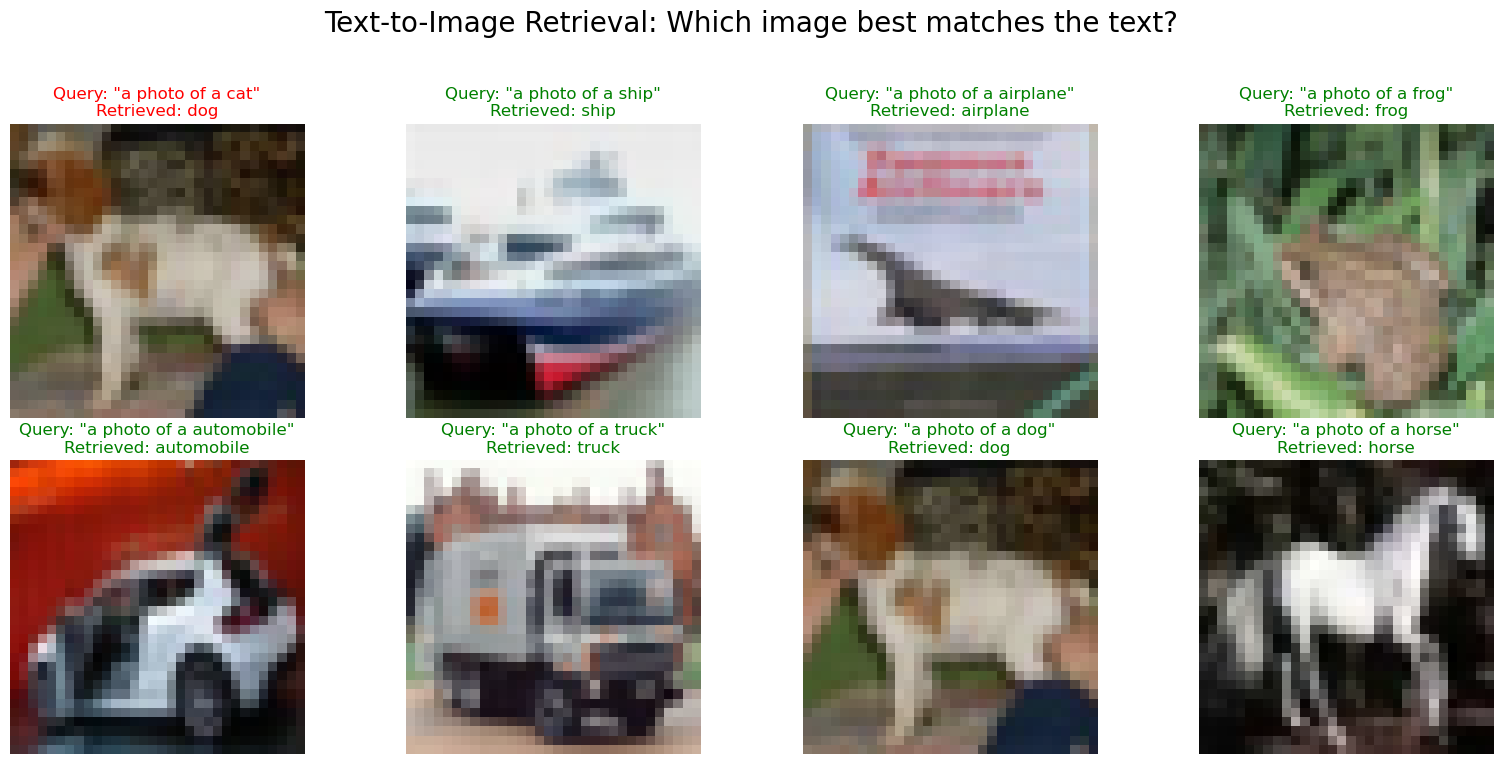


--- Image-to-Text Retrieval ---


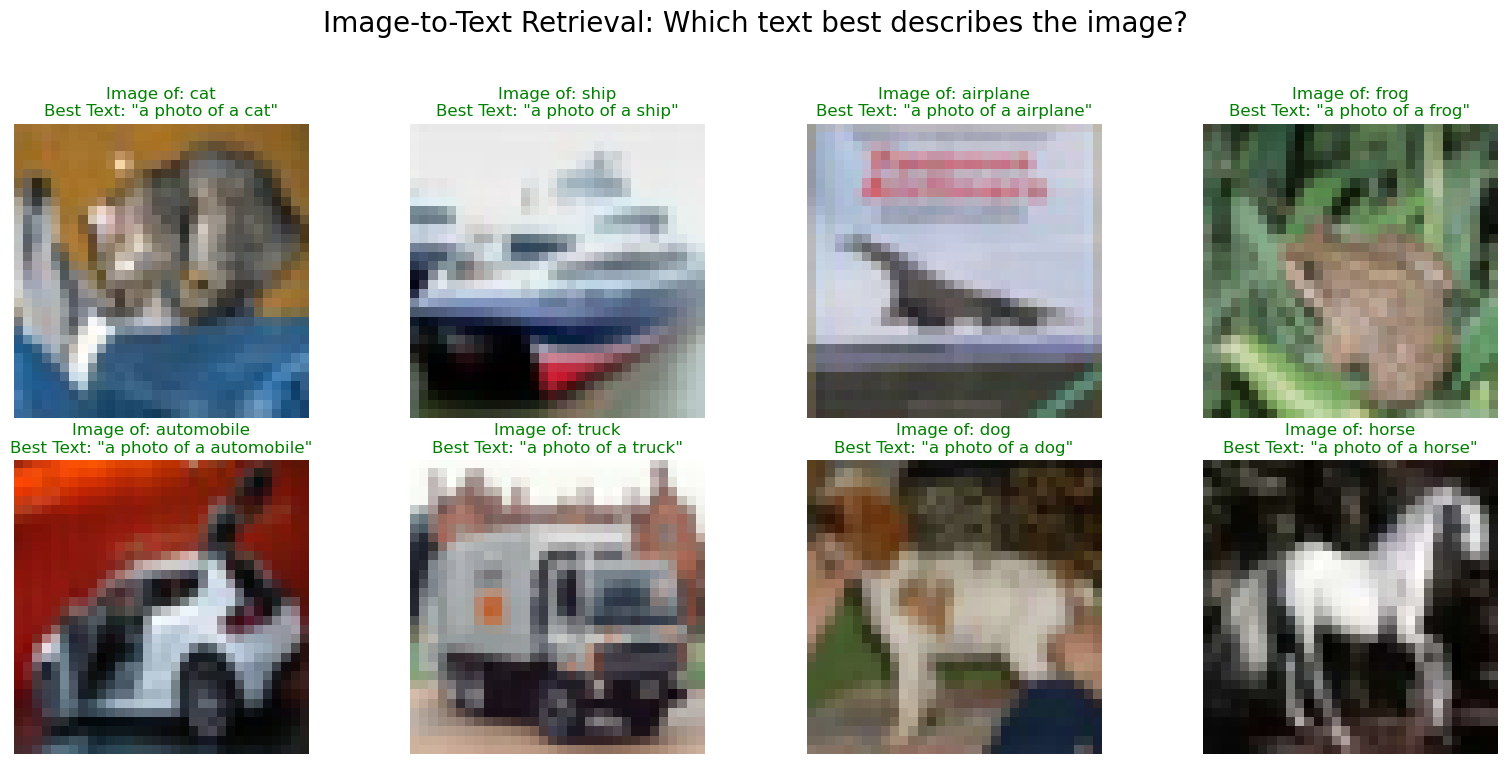

In [4]:
import torch
import clip
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


cifar10_vis = CIFAR10(root="./data", train=False, download=True)
cifar10_clip = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
class_names = cifar10_clip.classes


image_indices = []
images_to_show = []
images_preprocessed = []
labels_retrieved = []
seen_classes = set()

for i, (img, label) in enumerate(cifar10_vis):
    if len(image_indices) >= 8:
        break
    if label not in seen_classes:
        seen_classes.add(label)
        image_indices.append(i)
        images_to_show.append(img) 
        images_preprocessed.append(cifar10_clip[i][0]) 
        labels_retrieved.append(class_names[label])


image_input = torch.stack(images_preprocessed).to(device)
print("Selected classes for retrieval test:", labels_retrieved)

text_queries = [f"a photo of a {label}" for label in labels_retrieved]
text_input = clip.tokenize(text_queries).to(device)



with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_input)
   
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)


print("\n--- Text-to-Image Retrieval ---")

similarity = (100.0 * text_features @ image_features.T)
probs = similarity.softmax(dim=-1)
top_matches = probs.argmax(dim=1)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Text-to-Image Retrieval: Which image best matches the text?", fontsize=20)
for i, ax in enumerate(axes.flatten()):
    query = text_queries[i]
    retrieved_idx = top_matches[i].item()
    retrieved_image = images_to_show[retrieved_idx]
    
    ax.imshow(retrieved_image)
    ax.set_title(f"Query: \"{query}\"\nRetrieved: {labels_retrieved[retrieved_idx]}",
                 color=("green" if labels_retrieved[i] == labels_retrieved[retrieved_idx] else "red"))
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



print("\n--- Image-to-Text Retrieval ---")
top_text_matches = probs.argmax(dim=0)


fig, axes = plt.subplots(2, 4, figsize=(16, 8)) 
fig.suptitle("Image-to-Text Retrieval: Which text best describes the image?", fontsize=20)

for i, ax in enumerate(axes.flatten()):
    image = images_to_show[i]
    true_label = labels_retrieved[i]
    retrieved_idx = top_text_matches[i].item()
    retrieved_text = text_queries[retrieved_idx]
    
    ax.imshow(image)
    ax.set_title(f"Image of: {true_label}\nBest Text: \"{retrieved_text}\"",
                 color=("green" if labels_retrieved[i] == labels_retrieved[retrieved_idx] else "red"),
                 fontsize=12) 
    ax.axis('off')


# plt.subplots_adjust(hspace=0.4) 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


PART 4:

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Extracting CLIP features...
Extracting ResNet features...
Running t-SNE for CLIP... (this may take a moment)


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE for ResNet...


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\xylic\AppData\Local\Temp\ipykernel_12044\4211870684.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 7)


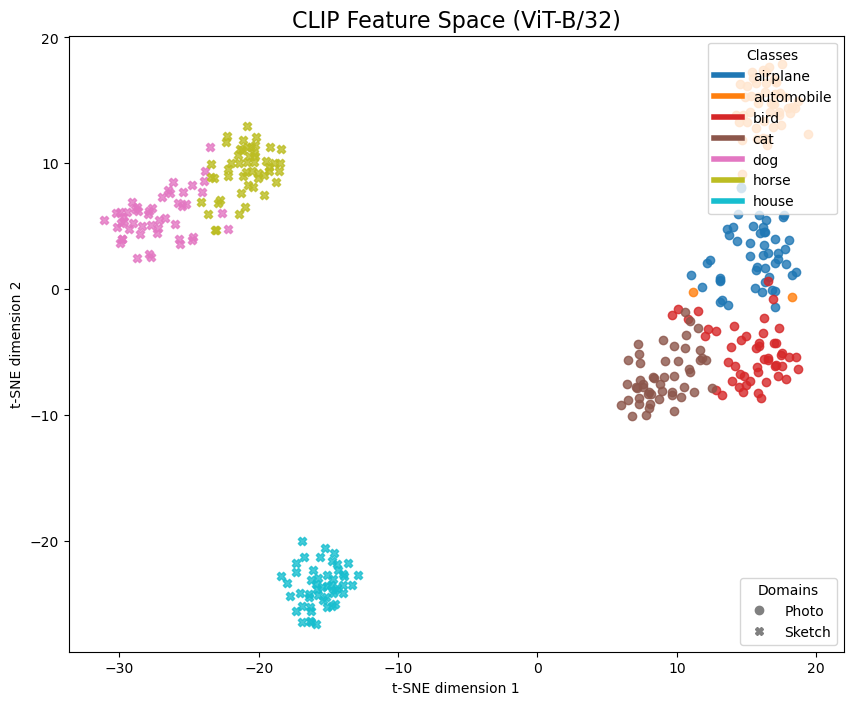

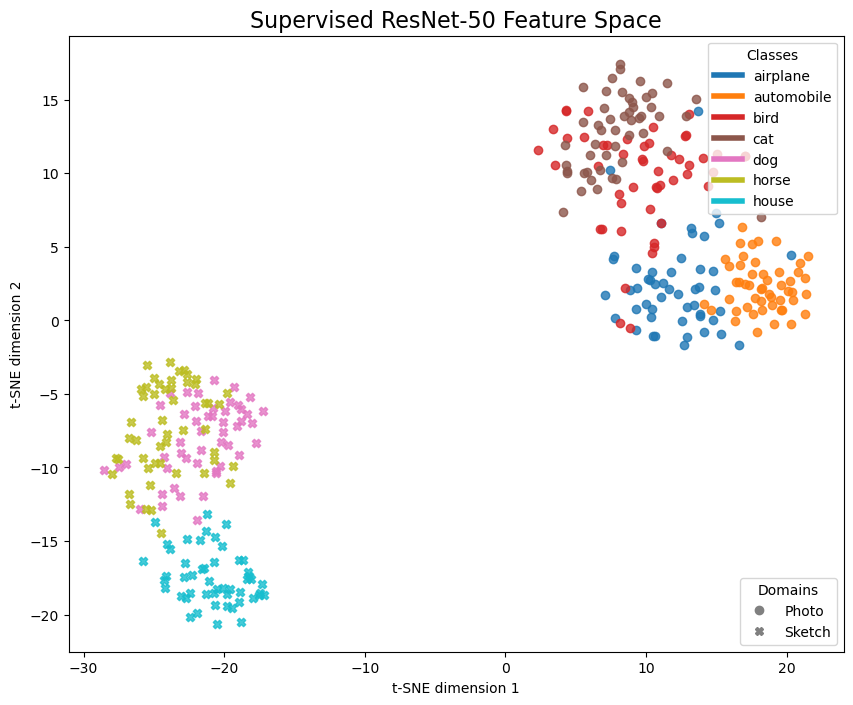

In [5]:

import torch
import clip
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, ImageFolder
from torch.utils.data import Subset, ConcatDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)



resnet_model = models.resnet50(pretrained=True).to(device)

resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model.eval()


resnet_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


NUM_SAMPLES_PER_CLASS = 50


cifar_clip = CIFAR10(root="./data", train=False, download=True, transform=clip_preprocess)
cifar_resnet = CIFAR10(root="./data", train=False, download=True, transform=resnet_preprocess)
cifar_labels = np.array(cifar_clip.targets)
cifar_indices = []

for i in range(4): 
    cifar_indices.extend(np.where(cifar_labels == i)[0][:NUM_SAMPLES_PER_CLASS])


sketch_path = 'pacs_data/pacs_data/sketch' 

pacs_class_map = {'dog': 4, 'horse': 5, 'house': 6} 

sketch_clip = ImageFolder(root=sketch_path, transform=clip_preprocess)
sketch_resnet = ImageFolder(root=sketch_path, transform=resnet_preprocess)
sketch_labels = np.array([s[1] for s in sketch_clip.samples])
sketch_class_names = sketch_clip.classes
sketch_indices = []

for name, idx in pacs_class_map.items():
    class_idx_in_pacs = sketch_class_names.index(name)
    sketch_indices.extend(np.where(sketch_labels == class_idx_in_pacs)[0][:NUM_SAMPLES_PER_CLASS])


all_labels = []
all_domains = [] 
all_clip_images = []
all_resnet_images = []

for i in cifar_indices:
    all_clip_images.append(cifar_clip[i][0])
    all_resnet_images.append(cifar_resnet[i][0])
    all_labels.append(cifar_clip[i][1])
    all_domains.append(0)

for i in sketch_indices:
    
    original_pacs_label = sketch_clip[i][1]
    mapped_label = pacs_class_map[sketch_class_names[original_pacs_label]]
    
    all_clip_images.append(sketch_clip[i][0])
    all_resnet_images.append(sketch_resnet[i][0])
    all_labels.append(mapped_label)
    all_domains.append(1)

@torch.no_grad()
def extract_features(model, images, is_clip=False):
    features = []
    image_tensor = torch.stack(images).to(device)
    
    if is_clip:
        features = model.encode_image(image_tensor).cpu().numpy()
    else: 
        features = model(image_tensor).squeeze().cpu().numpy()
    
    return features

print("Extracting CLIP features...")
clip_features = extract_features(clip_model, all_clip_images, is_clip=True)
print("Extracting ResNet features...")
resnet_features = extract_features(resnet_model, all_resnet_images)


print("Running t-SNE for CLIP... (this may take a moment)")
tsne_clip = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_clip_results = tsne_clip.fit_transform(clip_features)

print("Running t-SNE for ResNet...")
tsne_resnet = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_resnet_results = tsne_resnet.fit_transform(resnet_features)


def plot_tsne(tsne_results, labels, domains, title):
    plt.figure(figsize=(10, 8))
   
    colors = plt.cm.get_cmap('tab10', 7)
    
    markers = ['o', 'X'] 
    domain_names = ['Photo', 'Sketch']

    for i in range(len(tsne_results)):
        plt.scatter(
            tsne_results[i, 0], tsne_results[i, 1],
            color=colors(labels[i]),
            marker=markers[domains[i]],
            alpha=0.8
        )
    

    class_legend = [plt.Line2D([0], [0], color=colors(i), lw=4) for i in range(7)]
    class_names = cifar_clip.classes[:4] + list(pacs_class_map.keys())
    l1 = plt.legend(class_legend, class_names, title="Classes", loc='upper right')
    
    domain_legend = [plt.Line2D([0], [0], color='gray', marker=m, linestyle='None') for m in markers]
    l2 = plt.legend(domain_legend, domain_names, title="Domains", loc='lower right')
    plt.gca().add_artist(l1)

    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

plot_tsne(tsne_clip_results, all_labels, all_domains, "CLIP Feature Space (ViT-B/32)")
plot_tsne(tsne_resnet_results, all_labels, all_domains, "Supervised ResNet-50 Feature Space")

Files already downloaded and verified
Files already downloaded and verified


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\xylic\AppData\Local\Temp\ipykernel_26504\1674947979.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 7)


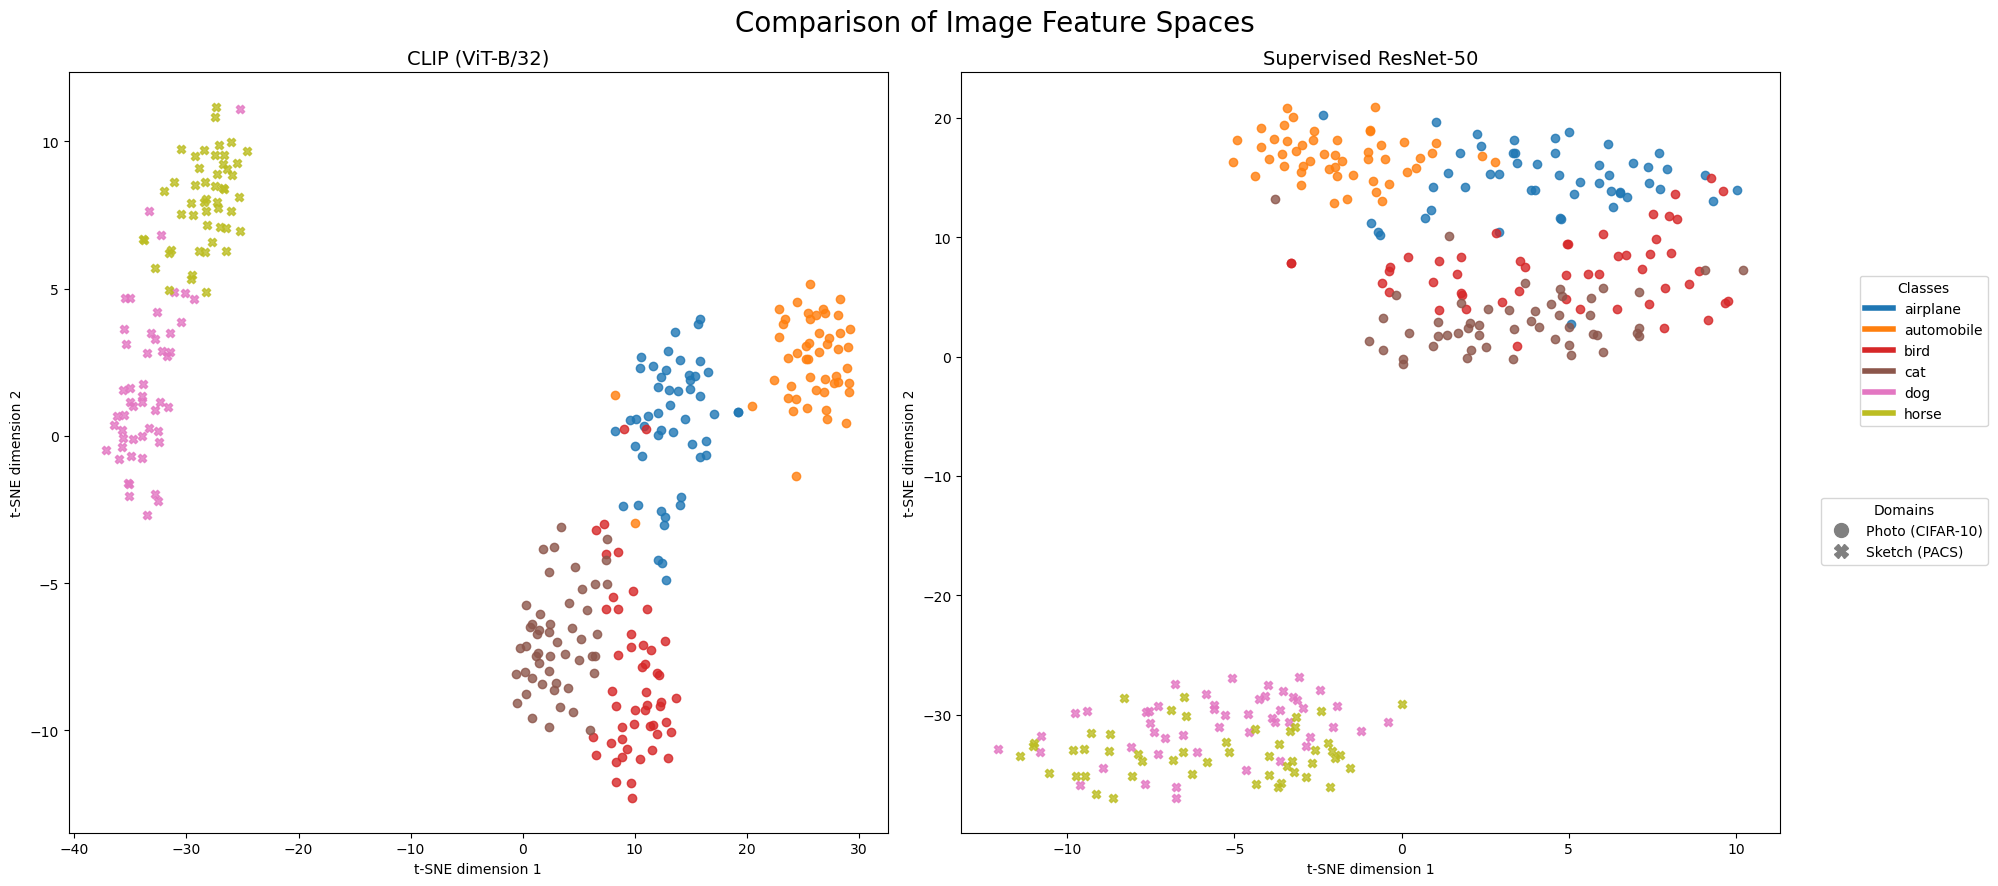

In [ ]:
import torch
import clip
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, ImageFolder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
resnet_model = models.resnet50(pretrained=True).to(device)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model.eval()
resnet_preprocess = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


NUM_SAMPLES_PER_CLASS = 50
cifar_clip = CIFAR10(root="./data", train=False, download=True, transform=clip_preprocess)
cifar_resnet = CIFAR10(root="./data", train=False, download=True, transform=resnet_preprocess)
cifar_labels = np.array(cifar_clip.targets)
cifar_indices = []
for i in range(4): 
    cifar_indices.extend(np.where(cifar_labels == i)[0][:NUM_SAMPLES_PER_CLASS])

sketch_path = 'pacs_data/pacs_data/sketch' 
pacs_class_map = {'dog': 4, 'horse': 5}
sketch_clip = ImageFolder(root=sketch_path, transform=clip_preprocess)
sketch_resnet = ImageFolder(root=sketch_path, transform=resnet_preprocess)
sketch_labels = np.array([s[1] for s in sketch_clip.samples])
sketch_class_names = sketch_clip.classes
sketch_indices = []
for name, idx in pacs_class_map.items():
    class_idx_in_pacs = sketch_class_names.index(name)
    sketch_indices.extend(np.where(sketch_labels == class_idx_in_pacs)[0][:NUM_SAMPLES_PER_CLASS])

all_labels, all_domains = [], []
all_clip_images, all_resnet_images = [], []
for i in cifar_indices:
    all_clip_images.append(cifar_clip[i][0]); all_resnet_images.append(cifar_resnet[i][0])
    all_labels.append(cifar_clip[i][1]); all_domains.append(0)
for i in sketch_indices:
    original_pacs_label = sketch_clip[i][1]
    mapped_label = pacs_class_map[sketch_class_names[original_pacs_label]]
    all_clip_images.append(sketch_clip[i][0]); all_resnet_images.append(sketch_resnet[i][0])
    all_labels.append(mapped_label); all_domains.append(1)


@torch.no_grad()
def extract_features(model, images, is_clip=False):
    features = model.encode_image(torch.stack(images).to(device)).cpu().numpy() if is_clip else model(torch.stack(images).to(device)).squeeze().cpu().numpy()
    return features
clip_features = extract_features(clip_model, all_clip_images, is_clip=True)
resnet_features = extract_features(resnet_model, all_resnet_images)


tsne_clip_results = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(clip_features)
tsne_resnet_results = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(resnet_features)


def plot_tsne_subplot(ax, tsne_results, labels, domains, title):
    colors = plt.cm.get_cmap('tab10', 7)
    markers = ['o', 'X'] 
    for i in range(len(tsne_results)):
        ax.scatter(tsne_results[i, 0], tsne_results[i, 1], color=colors(labels[i]), marker=markers[domains[i]], alpha=0.8)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("t-SNE dimension 1")
    ax.set_ylabel("t-SNE dimension 2")
    return colors, markers

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Comparison of Image Feature Spaces', fontsize=20)

colors, markers = plot_tsne_subplot(ax1, tsne_clip_results, all_labels, all_domains, "CLIP (ViT-B/32)")
plot_tsne_subplot(ax2, tsne_resnet_results, all_labels, all_domains, "Supervised ResNet-50")


class_legend = [plt.Line2D([0], [0], color=colors(i), lw=4) for i in range(len(pacs_class_map) + 4)]
class_names = cifar_clip.classes[:4] + list(pacs_class_map.keys())
l1 = fig.legend(class_legend, class_names, title="Classes", loc='center right', bbox_to_anchor=(1.0, 0.6))

domain_legend = [plt.Line2D([0], [0], color='gray', marker=m, linestyle='None', markersize=10) for m in markers]
l2 = fig.legend(domain_legend, ['Photo (CIFAR-10)', 'Sketch (PACS)'], title="Domains", loc='center right', bbox_to_anchor=(1.0, 0.4))

plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.show()

PART 5

--- Shape vs. Texture/Style Bias Test ---
Analyzing a sketch of a dog:


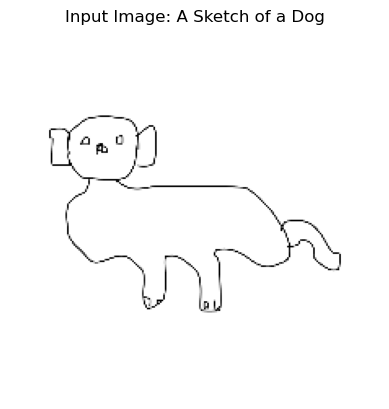


CLIP's confidence scores for different text prompts:
  - Prompt: "a sketch of a dog" -> Confidence: 25.34%
  - Prompt: "a drawing of a dog" -> Confidence: 68.90%
  - Prompt: "a dog with four legs and a tail" -> Confidence: 4.34%
  - Prompt: "a photo of a dog" -> Confidence: 1.28%
  - Prompt: "a furry animal with floppy ears" -> Confidence: 0.04%
  - Prompt: "a sketch of a cat" -> Confidence: 0.07%


In [ ]:
torch.cuda.empty_cache()
import torch
import clip
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


sketch_path = 'pacs_data/pacs_data/sketch'
sketch_dataset = ImageFolder(root=sketch_path, transform=preprocess)


dog_class_index = sketch_dataset.class_to_idx['dog']
dog_image_index = [i for i, label in enumerate(sketch_dataset.targets) if label == dog_class_index][0]


dog_image_tensor = sketch_dataset[dog_image_index][0].unsqueeze(0).to(device)
original_dog_image = sketch_dataset.imgs[dog_image_index][0]



text_prompts = [
    "a sketch of a dog",
    "a drawing of a dog",
    "a dog with four legs and a tail", 
    "a photo of a dog",         
    "a furry animal with floppy ears", 
    "a sketch of a cat",           
]

text_inputs = clip.tokenize(text_prompts).to(device)


with torch.no_grad():
    image_features = model.encode_image(dog_image_tensor)
    text_features = model.encode_text(text_inputs)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T)
    probs = similarity.softmax(dim=-1)


print("--- Shape vs. Texture/Style Bias Test ---")
print("Analyzing a sketch of a dog:")

plt.imshow(plt.imread(original_dog_image))
plt.title("Input Image: A Sketch of a Dog")
plt.axis('off')
plt.show()

print("\nCLIP's confidence scores for different text prompts:")
for i, prompt in enumerate(text_prompts):
    print(f"  - Prompt: \"{prompt}\" -> Confidence: {probs[0, i].item():.2%}")

PART 6:

Files already downloaded and verified


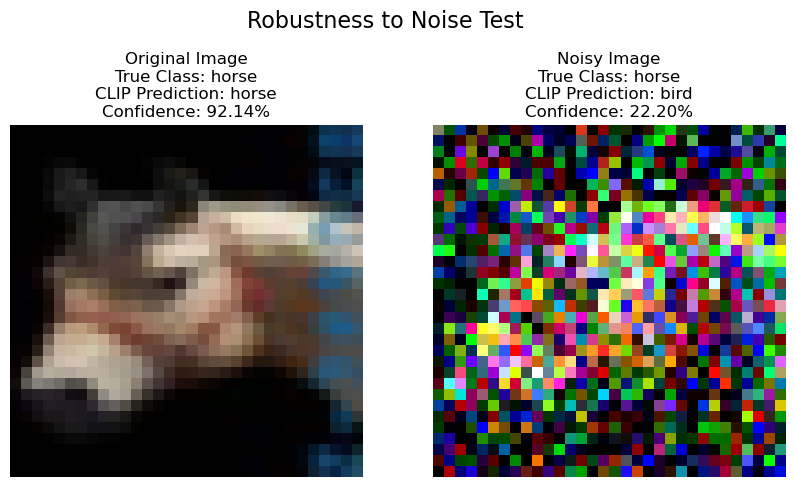

In [7]:
import torch
import clip
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


cifar_vis = CIFAR10(root="./data", train=False, download=True)
class_names = cifar_vis.classes


horse_class_index = class_names.index('horse')
horse_index = [i for i, label in enumerate(cifar_vis.targets) if label == horse_class_index][5] 
original_image, true_label = cifar_vis[horse_index]


noise_intensity = 0.4
noisy_image = np.array(original_image) + np.random.normal(0, 255 * noise_intensity, (32, 32, 3))
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
noisy_image = Image.fromarray(noisy_image)

original_image_tensor = preprocess(original_image).unsqueeze(0).to(device)
noisy_image_tensor = preprocess(noisy_image).unsqueeze(0).to(device)


text_prompts = [f"a photo of a {c}" for c in class_names]
text_inputs = clip.tokenize(text_prompts).to(device)


with torch.no_grad():

    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    original_image_features = model.encode_image(original_image_tensor)
    original_image_features /= original_image_features.norm(dim=-1, keepdim=True)
    original_probs = (100.0 * original_image_features @ text_features.T).softmax(dim=-1)
    original_pred_idx = original_probs.argmax().item()
    original_pred_label = class_names[original_pred_idx]
    original_confidence = original_probs.max().item()
    
    noisy_image_features = model.encode_image(noisy_image_tensor)
    noisy_image_features /= noisy_image_features.norm(dim=-1, keepdim=True)
    noisy_probs = (100.0 * noisy_image_features @ text_features.T).softmax(dim=-1)
    noisy_pred_idx = noisy_probs.argmax().item()
    noisy_pred_label = class_names[noisy_pred_idx]
    noisy_confidence = noisy_probs.max().item()


fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Robustness to Noise Test", fontsize=16)

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image\nTrue Class: {class_names[true_label]}\nCLIP Prediction: {original_pred_label}\nConfidence: {original_confidence:.2%}")
axes[0].axis('off')

axes[1].imshow(noisy_image)
axes[1].set_title(f"Noisy Image\nTrue Class: {class_names[true_label]}\nCLIP Prediction: {noisy_pred_label}\nConfidence: {noisy_confidence:.2%}")
axes[1].axis('off')

plt.show()